### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Function Definition

In [2]:
def plot_term_chart(data, text_feature, ngram_range=(1,1), stop_words='english'):
    # Create subplots with 1 by 2
    fig, ax = plt.subplots(figsize = (12,15), nrows=1, ncols=2)
    fig.tight_layout(pad=6)
    
    # Set color palette
    color_palette = {'LinusTechTips': 'darkorange', 'TrashTaste': 'purple'}
    
    # Count Vectorizer
    # Instantiate
    cvec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range, max_features=50)
    
    # Fit and transform data
    cvec.fit(data[text_feature])
    data_vec = cvec.transform(data[text_feature])
    data_vec_pd = pd.DataFrame(data_vec.toarray(), columns=cvec.get_feature_names())
    
    # Add subreddit column
    data_vec_pd['subreddit'] = data['subreddit']
    
    # Groupby, melt dataframe and sort by descending order using delta to create barplot comparison
    temp = data_vec_pd.groupby('subreddit').sum().T
    #temp['delta'] = abs(temp['LinusTechTips'] - temp['TrashTaste'])
    temp['delta'] = temp['LinusTechTips'] - temp['TrashTaste']
    temp.sort_values(by='delta',ascending=False, inplace=True)
    temp_melt = temp[['LinusTechTips', 'TrashTaste']].melt(ignore_index=False)
    sns.barplot(y=temp_melt.index, x=temp_melt['value'], hue=temp_melt['subreddit'], palette=color_palette, ax=ax[0])
    ax[0].set_title('Count Vectorizer Top 50 Terms', fontweight = 'bold', fontsize=15)
    
    # TF-IDF Vectorizer
    # Instantiate
    tvec = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram_range, max_features=50)
    
    # Fit and transform data
    tvec.fit(data[text_feature])
    data_vec = tvec.transform(data[text_feature])
    data_vec_pd = pd.DataFrame(data_vec.toarray(), columns=tvec.get_feature_names())
    
    # Add subreddit column
    data_vec_pd['subreddit'] = data['subreddit']
    
    # Groupby, melt dataframe and sort by descending order using delta to create barplot comparison
    temp = data_vec_pd.groupby('subreddit').sum().T
    #temp['delta'] = abs(temp['LinusTechTips'] - temp['TrashTaste'])
    temp['delta'] = temp['LinusTechTips'] - temp['TrashTaste']
    temp.sort_values(by='delta',ascending=False, inplace=True)
    temp_melt = temp[['LinusTechTips', 'TrashTaste']].melt(ignore_index=False)
    sns.barplot(y=temp_melt.index, x=temp_melt['value'], hue=temp_melt['subreddit'], palette=color_palette, ax=ax[1])
    ax[1].set_title('TF-IDF Vectorizer Top 50 Terms', fontweight = 'bold', fontsize=15)
    

### Load Data

In [3]:
linustech = pd.read_csv('../data/linustechtips.csv')
trashtaste = pd.read_csv('../data/trashtaste.csv')
data = pd.concat([linustech, trashtaste], ignore_index=True)
data.drop('Unnamed: 0', axis = 'columns', inplace=True)

### Clean Data

In [4]:
data.head()

all_awardings  allow_live_comments        author author_flair_css_class  \
0            []                False       jakze13                    NaN   
1            []                False     SpeedconG                    NaN   
2            []                False  Fab-Buns5166                    NaN   
3            []                False    dishitnuts                    NaN   
4            []                False    gekke_gijt                    NaN   

  author_flair_richtext author_flair_text author_flair_type author_fullname  \
0                    []               NaN              text     t2_45ruwko5   
1                    []               NaN              text     t2_60tn1a31   
2                    []               NaN              text     t2_jbr5sgus   
3                    []               NaN              text     t2_9vizihuc   
4                    []               NaN              text     t2_4bb6ae0s   

   author_is_blocked author_patreon_flair  ... gallery_data is_gallery  \
0              False                False  ...          NaN        NaN   
1              False                False  ...          NaN        NaN   
2              False                False  ...          NaN        NaN   
3              False                False  ...          NaN        NaN   
4              False                False  ...          NaN        NaN   

   media_metadata  author_flair_template_id  author_flair_text_color  \
0             NaN                       NaN                      NaN   
1             NaN                       NaN                      NaN   
2             NaN                       NaN                      NaN   
3             NaN                       NaN                      NaN   
4             NaN                       NaN                      NaN   

  poll_data author_flair_background_color author_cakeday distinguished  \
0       NaN                           NaN            NaN           NaN   
1       NaN                           NaN            NaN           NaN   
2       NaN                           NaN            NaN           NaN   
3       NaN                           NaN            NaN           NaN   
4       NaN                           NaN            NaN           NaN   

   banned_by  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

[5 rows x 85 columns]

In [5]:
data.shape

(4200, 85)

In [6]:
# Check Ratio of labels udner subreddit
data['subreddit'].value_counts(normalize=True)

LinusTechTips    0.5
TrashTaste       0.5
Name: subreddit, dtype: float64

In [7]:
# 3 types of data type: boolean, object/string, numeric
data.dtypes.unique()

array([dtype('O'), dtype('bool'), dtype('int64'), dtype('float64')],
      dtype=object)

In [8]:
# Check datatype of each features
features_obj=[]
features_bool=[]
features_num=[]
for col in data.columns:
    if data[col].dtypes == 'O':
        features_obj.append(col)
    elif data[col].dtypes == 'bool':
        features_bool.append(col)
    else:
        features_num.append(col)
        

In [9]:
features_obj

['all_awardings',
 'author',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_text',
 'author_flair_type',
 'author_fullname',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'domain',
 'full_link',
 'gildings',
 'id',
 'link_flair_background_color',
 'link_flair_css_class',
 'link_flair_richtext',
 'link_flair_template_id',
 'link_flair_text',
 'link_flair_text_color',
 'link_flair_type',
 'parent_whitelist_status',
 'permalink',
 'selftext',
 'subreddit',
 'subreddit_id',
 'subreddit_type',
 'suggested_sort',
 'thumbnail',
 'title',
 'treatment_tags',
 'url',
 'whitelist_status',
 'post_hint',
 'preview',
 'url_overridden_by_dest',
 'media',
 'media_embed',
 'secure_media',
 'secure_media_embed',
 'crosspost_parent',
 'crosspost_parent_list',
 'removed_by_category',
 'gallery_data',
 'is_gallery',
 'media_metadata',
 'author_flair_template_id',
 'author_flair_text_color',
 'poll_data',
 'author_flair_background_color',
 'author_cakeday',
 'distinguished',

In [10]:
features_bool

['allow_live_comments',
 'author_is_blocked',
 'can_mod_post',
 'contest_mode',
 'is_created_from_ads_ui',
 'is_crosspostable',
 'is_meta',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'is_video',
 'locked',
 'media_only',
 'no_follow',
 'over_18',
 'pinned',
 'send_replies',
 'spoiler',
 'stickied']

In [11]:
features_num

['created_utc',
 'num_comments',
 'num_crossposts',
 'pwls',
 'retrieved_on',
 'score',
 'subreddit_subscribers',
 'total_awards_received',
 'upvote_ratio',
 'wls',
 'thumbnail_height',
 'thumbnail_width']

#### Dropping features that provide the subreddit name or ID directly or indirectly

Dropping full_link, permalink and subreddit_id as they provide clear hints in distingushing the 2 subreddits.

In [12]:
data[['full_link', 'permalink', 'subreddit_id']]

full_link  \
0     https://www.reddit.com/r/LinusTechTips/comment...   
1     https://www.reddit.com/r/LinusTechTips/comment...   
2     https://www.reddit.com/r/LinusTechTips/comment...   
3     https://www.reddit.com/r/LinusTechTips/comment...   
4     https://www.reddit.com/r/LinusTechTips/comment...   
...                                                 ...   
4195  https://www.reddit.com/r/TrashTaste/comments/s...   
4196  https://www.reddit.com/r/TrashTaste/comments/s...   
4197  https://www.reddit.com/r/TrashTaste/comments/s...   
4198  https://www.reddit.com/r/TrashTaste/comments/s...   
4199  https://www.reddit.com/r/TrashTaste/comments/s...   

                                              permalink subreddit_id  
0     /r/LinusTechTips/comments/sups9k/cant_get_cpu_...     t5_2v5ru  
1     /r/LinusTechTips/comments/suneh4/linus_was_thi...     t5_2v5ru  
2         /r/LinusTechTips/comments/sumpbk/blue_screen/     t5_2v5ru  
3     /r/LinusTechTips/comments/sulhel/i_need_help_a...     t5_2v5ru  
4     /r/LinusTechTips/comments/sukkji/creepy_linus_...     t5_2v5ru  
...                                                 ...          ...  
4195  /r/TrashTaste/comments/sfdtws/the_audacity_of_...    t5_2p976a  
4196  /r/TrashTaste/comments/sfdtbz/garnt_should_rea...    t5_2p976a  
4197  /r/TrashTaste/comments/sfdnnh/chris_abroad_in_...    t5_2p976a  
4198  /r/TrashTaste/comments/sfdk75/its_your_boi_chr...    t5_2p976a  
4199  /r/TrashTaste/comments/sfd9jr/chris_broad_conf...    t5_2p976a  

[4200 rows x 3 columns]

In [13]:
data.drop(columns=['full_link', 'permalink', 'subreddit_id'], inplace = True)

#### Checking features with low percentage of null values

As the 8 rows that had null values are posts which were deleted and can longer be access on the website, these submissions were dropped from the data.

In [14]:
# Get features with less than 5% missing data
temp = data.isnull().sum()/data.shape[0]
temp[temp<0.05]

all_awardings              0.000000
allow_live_comments        0.000000
author                     0.000000
author_flair_richtext      0.001905
author_flair_type          0.001905
author_fullname            0.001905
author_is_blocked          0.000000
author_patreon_flair       0.001905
author_premium             0.001905
awarders                   0.000000
can_mod_post               0.000000
contest_mode               0.000000
created_utc                0.000000
domain                     0.000000
gildings                   0.000000
id                         0.000000
is_created_from_ads_ui     0.000000
is_crosspostable           0.000000
is_meta                    0.000000
is_original_content        0.000000
is_reddit_media_domain     0.000000
is_robot_indexable         0.000000
is_self                    0.000000
is_video                   0.000000
link_flair_css_class       0.031190
link_flair_richtext        0.000000
link_flair_text            0.031190
link_flair_text_color      0

In [15]:
data[data['author_flair_richtext'].isnull()]

all_awardings  allow_live_comments     author author_flair_css_class  \
338             []                False  [deleted]                    NaN   
502             []                False  [deleted]                    NaN   
1315            []                False  [deleted]                    NaN   
2672            []                False  [deleted]                    NaN   
3034            []                False  [deleted]                    NaN   
3149            []                False  [deleted]                    NaN   
3443            []                False  [deleted]                    NaN   
3840            []                False  [deleted]                    NaN   

     author_flair_richtext author_flair_text author_flair_type  \
338                    NaN               NaN               NaN   
502                    NaN               NaN               NaN   
1315                   NaN               NaN               NaN   
2672                   NaN               NaN               NaN   
3034                   NaN               NaN               NaN   
3149                   NaN               NaN               NaN   
3443                   NaN               NaN               NaN   
3840                   NaN               NaN               NaN   

     author_fullname  author_is_blocked author_patreon_flair  ...  \
338              NaN              False                  NaN  ...   
502              NaN              False                  NaN  ...   
1315             NaN              False                  NaN  ...   
2672             NaN              False                  NaN  ...   
3034             NaN              False                  NaN  ...   
3149             NaN              False                  NaN  ...   
3443             NaN              False                  NaN  ...   
3840             NaN              False                  NaN  ...   

     gallery_data is_gallery  media_metadata  author_flair_template_id  \
338           NaN        NaN             NaN                       NaN   
502           NaN        NaN             NaN                       NaN   
1315          NaN        NaN             NaN                       NaN   
2672          NaN        NaN             NaN                       NaN   
3034          NaN        NaN             NaN                       NaN   
3149          NaN        NaN             NaN                       NaN   
3443          NaN        NaN             NaN                       NaN   
3840          NaN        NaN             NaN                       NaN   

      author_flair_text_color poll_data author_flair_background_color  \
338                      dark       NaN                           NaN   
502                      dark       NaN                           NaN   
1315                     dark       NaN                           NaN   
2672                     dark       NaN                           NaN   
3034                     dark       NaN                           NaN   
3149                     dark       NaN                           NaN   
3443                     dark       NaN                           NaN   
3840                     dark       NaN                           NaN   

     author_cakeday  distinguished   banned_by  
338             NaN            NaN         NaN  
502             NaN            NaN         NaN  
1315            NaN            NaN         NaN  
2672            NaN            NaN         NaN  
3034            NaN            NaN         NaN  
3149            NaN            NaN  moderators  
3443            NaN            NaN         NaN  
3840            NaN            NaN         NaN  

[8 rows x 82 columns]

In [16]:
data.dropna(subset=['author_flair_richtext'], inplace=True)

#### Droppping features which only has 1 or less label

Dropping features that only has 0 or 1 unique values as they would not be useful in determining which subreddit each submission comes from.

In [17]:
# Check how many features that has unique values less than or equal to 1
temp = data.nunique().sort_values(ascending=True)
temp[temp<=1]

banned_by                 0
author_cakeday            1
is_gallery                1
treatment_tags            1
total_awards_received     1
suggested_sort            1
subreddit_type            1
distinguished             1
num_crossposts            1
media_only                1
locked                    1
link_flair_text_color     1
is_original_content       1
is_meta                   1
is_created_from_ads_ui    1
gildings                  1
all_awardings             1
pinned                    1
awarders                  1
author_is_blocked         1
author_flair_css_class    1
author_patreon_flair      1
contest_mode              1
can_mod_post              1
dtype: int64

In [18]:
data.drop(columns=temp[temp<=1].index, inplace=True)

#### Update features remaining

In [19]:
# Check datatype of each features
features_obj=[]
features_bool=[]
features_num=[]
for col in data.columns:
    if data[col].dtypes == 'O':
        features_obj.append(col)
    elif data[col].dtypes == 'bool':
        features_bool.append(col)
    else:
        features_num.append(col)

#### Fill all missing data from object features as empty string

In [20]:
for feature in features_obj:
    data[feature].fillna('', inplace=True)

In [21]:
data.isnull().sum()

allow_live_comments                 0
author                              0
author_flair_richtext               0
author_flair_text                   0
author_flair_type                   0
author_fullname                     0
author_premium                      0
created_utc                         0
domain                              0
id                                  0
is_crosspostable                    0
is_reddit_media_domain              0
is_robot_indexable                  0
is_self                             0
is_video                            0
link_flair_background_color         0
link_flair_css_class                0
link_flair_richtext                 0
link_flair_template_id              0
link_flair_text                     0
link_flair_type                     0
no_follow                           0
num_comments                        0
over_18                             0
parent_whitelist_status             0
pwls                                0
retrieved_on

#### Removing rows with [removed] or [deleted] in selftext

To remove posts with [removed] or [deleted] in selftext as those posts were either deleted by author, moderator or reddit. They might be spam posts or not adhering to the community guidelines and might not represent the kind of post allowed on the subreddit.

In [22]:
# Dropping rows with [deleted] or [removed] in selftext
data.drop(index=data[data['selftext'].str.contains('\[removed\]|\[deleted\]')].index, inplace=True)

#### Converting epoch (in seconds) to UTC date and time

To convert the epoch time which are in seconds to human readable UTC date-time format, year, month, day, hour, minute and second.

In [64]:
data['created_datetime'] = pd.to_datetime(data['created_utc'], unit='s')
data['created_year'] = pd.DatetimeIndex(data['created_datetime']).year
data['created_month'] = pd.DatetimeIndex(data['created_datetime']).month
data['created_day'] = pd.DatetimeIndex(data['created_datetime']).day
data['created_hour'] = pd.DatetimeIndex(data['created_datetime']).hour
data['created_minute'] = pd.DatetimeIndex(data['created_datetime']).minute
data['created_second'] = pd.DatetimeIndex(data['created_datetime']).second

In [65]:
# Checking that data is converted correctly
data[['created_datetime', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_minute', 'created_second']]

created_datetime  created_year  created_month  created_day  \
0    2022-02-17 14:14:06          2022              2           17   
1    2022-02-17 12:12:54          2022              2           17   
2    2022-02-17 11:32:13          2022              2           17   
3    2022-02-17 10:14:42          2022              2           17   
4    2022-02-17 09:12:08          2022              2           17   
...                  ...           ...            ...          ...   
4195 2022-01-29 08:35:09          2022              1           29   
4196 2022-01-29 08:33:53          2022              1           29   
4197 2022-01-29 08:22:54          2022              1           29   
4198 2022-01-29 08:16:09          2022              1           29   
4199 2022-01-29 07:56:09          2022              1           29   

      created_hour  created_minute  created_second  
0               14              14               6  
1               12              12              54  
2               11              32              13  
3               10              14              42  
4                9              12               8  
...            ...             ...             ...  
4195             8              35               9  
4196             8              33              53  
4197             8              22              54  
4198             8              16               9  
4199             7              56               9  

[4156 rows x 7 columns]

In [118]:
data.sort_values(by=['subreddit', 'created_datetime'], ascending=False, inplace=True, ignore_index=True)
for i in range(data.shape[0]-1):
    if data.loc[i, 'subreddit'] == data.loc[i+1, 'subreddit']:
        data.loc[i, 'time_btw_post'] = data.loc[i, 'created_datetime'] - data.loc[i+1, 'created_datetime']
    else:
        data.loc[i, 'time_btw_post'] = data[data['subreddit']==data.loc[i, 'subreddit']]['time_btw_post'].mean()
    data.loc[data.shape[0]-1, 'time_btw_post'] = data[data['subreddit']==data.loc[data.shape[0]-1, 'subreddit']]['time_btw_post'].mean()

In [122]:
data['time_btw_post_(mins)'] = data['time_btw_post'] / np.timedelta64(1, 'm')

In [121]:
data['time_btw_post']

0                0 days 00:27:19
1                0 days 00:09:25
2                0 days 00:04:17
3                0 days 00:25:17
4                0 days 00:01:15
                  ...           
4151             0 days 00:38:56
4152             0 days 00:21:14
4153             0 days 00:06:53
4154             0 days 00:00:55
4155   0 days 00:48:14.857074340
Name: time_btw_post, Length: 4156, dtype: timedelta64[ns]

In [95]:
data
data[['created_datetime', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_minute', 'created_second', 'time_btw_post']]

created_datetime  created_year  created_month  created_day  \
0    2022-02-17 13:50:29          2022              2           17   
1    2022-02-17 13:23:10          2022              2           17   
2    2022-02-17 13:13:45          2022              2           17   
3    2022-02-17 13:09:28          2022              2           17   
4    2022-02-17 12:44:11          2022              2           17   
...                  ...           ...            ...          ...   
4151 2021-12-09 18:45:47          2021             12            9   
4152 2021-12-09 18:06:51          2021             12            9   
4153 2021-12-09 17:45:37          2021             12            9   
4154 2021-12-09 17:38:44          2021             12            9   
4155 2021-12-09 17:37:49          2021             12            9   

      created_hour  created_minute  created_second             time_btw_post  
0               13              50              29           0 days 00:27:19  
1               13              23              10           0 days 00:09:25  
2               13              13              45           0 days 00:04:17  
3               13               9              28           0 days 00:25:17  
4               12              44              11           0 days 00:01:15  
...            ...             ...             ...                       ...  
4151            18              45              47           0 days 00:38:56  
4152            18               6              51           0 days 00:21:14  
4153            17              45              37           0 days 00:06:53  
4154            17              38              44           0 days 00:00:55  
4155            17              37              49 0 days 00:48:14.857074340  

[4156 rows x 8 columns]

In [97]:
data[data['subreddit']=='LinusTechTips']

allow_live_comments                author author_flair_richtext  \
2070                False               jakze13                    []   
2071                False             SpeedconG                    []   
2072                False          Fab-Buns5166                    []   
2073                False            dishitnuts                    []   
2074                False            gekke_gijt                    []   
...                   ...                   ...                   ...   
4151                False          linusbottips                    []   
4152                False  First-Association-44                    []   
4153                False      clueless_as_fuck                    []   
4154                False            RabiSzlomo                    []   
4155                False        OreoGamingGeek                    []   

     author_flair_text author_flair_type author_fullname  author_premium  \
2070                                text     t2_45ruwko5           False   
2071                                text     t2_60tn1a31           False   
2072                                text     t2_jbr5sgus           False   
2073                                text     t2_9vizihuc           False   
2074                                text     t2_4bb6ae0s           False   
...                ...               ...             ...             ...   
4151                                text     t2_3dkdwf28           False   
4152                                text     t2_fr9dy7af           False   
4153                                text        t2_i8ngy           False   
4154                                text      t2_apnbbgg           False   
4155                                text      t2_c9jmyy4           False   

      created_utc                                             domain      id  \
2070   1645107246                                 self.LinusTechTips  sups9k   
2071   1645099974                                          i.redd.it  suneh4   
2072   1645097533                                 self.LinusTechTips  sumpbk   
2073   1645092882                                 self.LinusTechTips  sulhel   
2074   1645089128                                          i.redd.it  sukkji   
...           ...                                                ...     ...   
4151   1639075547                                        youtube.com  rco6rn   
4152   1639073211  /r/LinusTechTips/comments/rcncz7/i_didnt_know_...  rcncz7   
4153   1639071937                                           youtu.be  rcmwcj   
4154   1639071524                                          i.redd.it  rcmr4r   
4155   1639071469                                          i.redd.it  rcmqdo   

      ...  poll_data  author_flair_background_color    created_datetime  \
2070  ...                                           2022-02-17 14:14:06   
2071  ...                                           2022-02-17 12:12:54   
2072  ...                                           2022-02-17 11:32:13   
2073  ...                                           2022-02-17 10:14:42   
2074  ...                                           2022-02-17 09:12:08   
...   ...        ...                            ...                 ...   
4151  ...                                           2021-12-09 18:45:47   
4152  ...                                           2021-12-09 18:06:51   
4153  ...                                           2021-12-09 17:45:37   
4154  ...                                           2021-12-09 17:38:44   
4155  ...                                           2021-12-09 17:37:49   

      created_year  created_month created_day created_hour created_minute  \
2070          2022              2          17           14             14   
2071          2022              2          17           12             12   
2072          2022              2          17           11             32   
2073          2022              2          17 

### EDA

#### Title Common Terms
Generally both subreddits do not have very high overlap for those high frequency occurring words.
For LinusTechTips, common terms are linus, pc, help, ltt and gpu while for TrashTaste, they are connor, garnt, chris, taste and joey which are mainly the hosts' or guest's name.

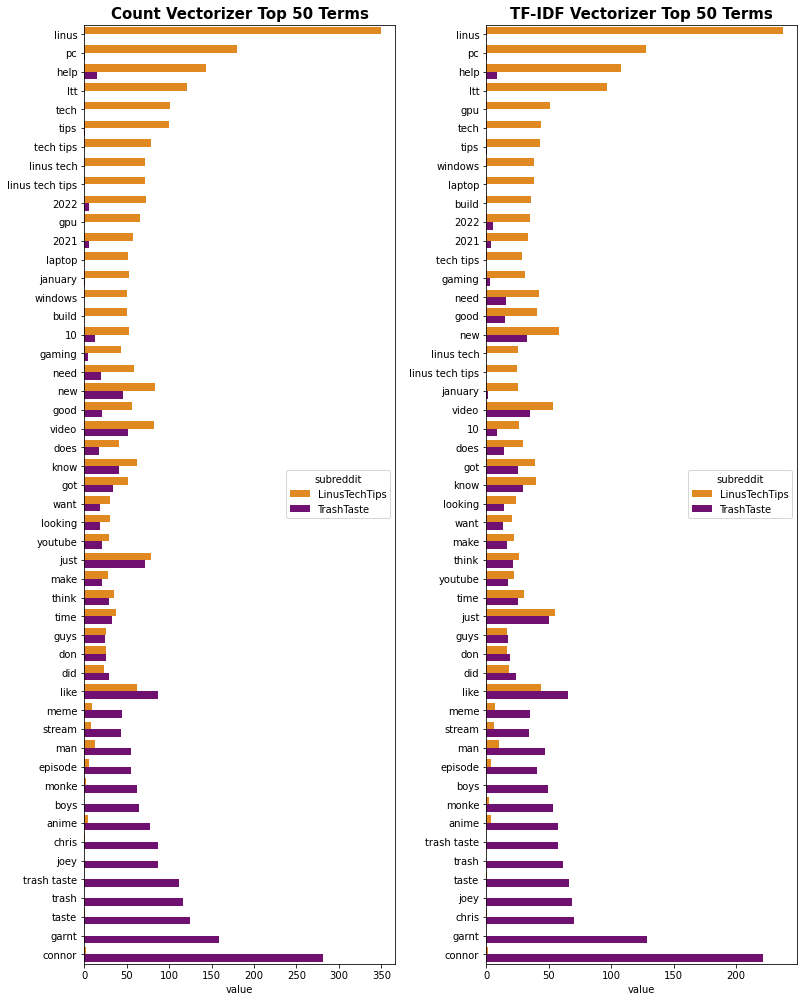

In [23]:
# Check top 50 terms for title
plot_term_chart(data, 'title', ngram_range=(1,3))

#### Selftext Common Terms

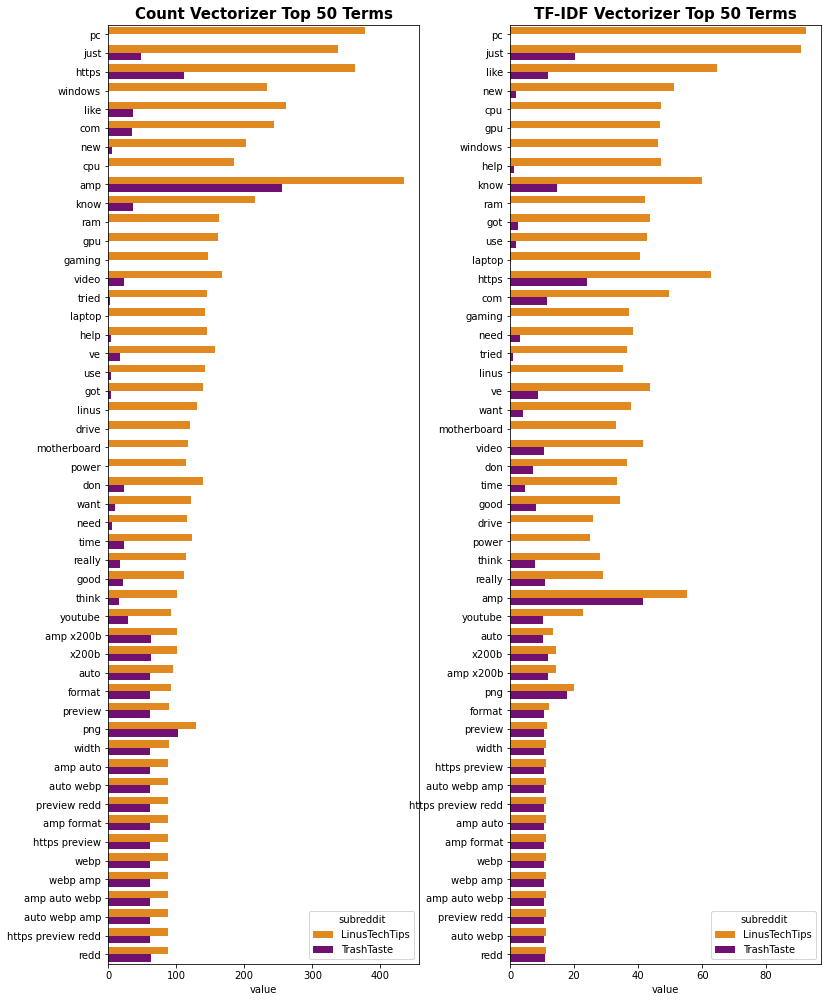

In [24]:
# Check top 50 terms for selftext
plot_term_chart(data, 'selftext', ngram_range=(1,3))

#### Any Overlapping Authors

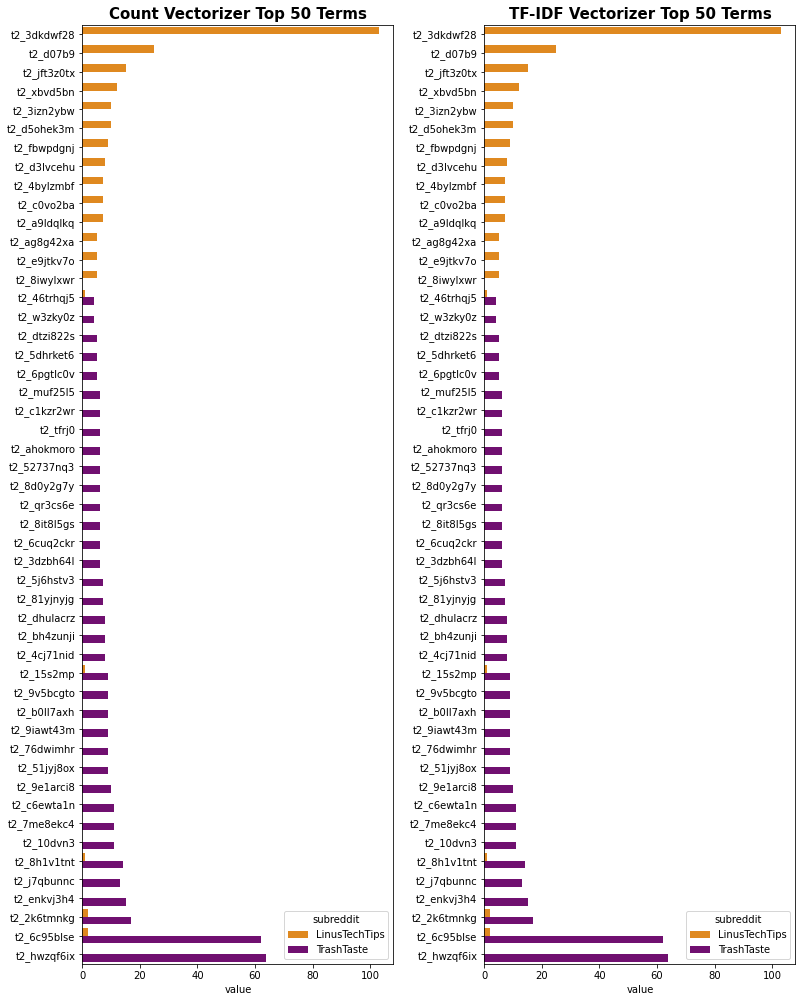

In [25]:
# Check top 50 terms for author_fullname
plot_term_chart(data, 'author_fullname', ngram_range=(1,3))

#### Does Subreddit Affects the Type of Ads Shown?

Usually the content of the posts would affect the kind of ads shown on a website as no advertiser would like to associate themselves with a post that might be inappropriate. From the analysis, LinusTechTips has a larger share of posts that are eligible for any ads as they are more family-friendly while TrashTaste, on the other hand, are only eligible for some ads.

Text(0, 0.5, 'Subreddit, Types of Ads Eligible')

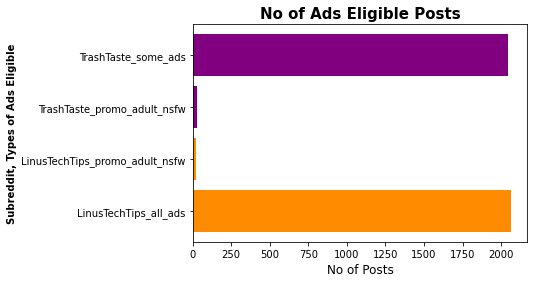

In [26]:
# To determine if the subreddit affects the type of ads
temp = data[['whitelist_status', 'subreddit', 'wls']].groupby(['subreddit', 'whitelist_status'])['wls'].count()
plt.barh(y=[subreddit + "_" + ads for subreddit, ads in temp.index], width=temp, 
         color=['darkorange', 'darkorange', 'purple', 'purple'])
plt.title('No of Ads Eligible Posts', fontweight = 'bold', fontsize=15)
plt.xlabel('No of Posts', fontsize=12)
plt.ylabel('Subreddit, Types of Ads Eligible', fontweight = 'bold', fontsize=10)

In [27]:
data['link_flair_text'].nunique()

50

#### Determining how 'link_flair_text' changes with subreddit

In [28]:
data['link_flair_text'].value_counts()

Meme                                            1132
Discussion                                       564
Image                                            457
Tech Question                                    392
S***post                                         269
Screenshot                                       233
Video                                            190
Clip                                             139
Other                                            135
                                                 130
Tweet                                            101
Question                                          90
Suggestion                                        71
Art                                               66
WAN Show                                          49
Tech Discussion                                   35
Video Idea!                                       24
Quote                                             15
Link                                          

In [29]:
data[data['subreddit']=='TrashTaste']['link_flair_text'].unique()

array(['Suggestion', 'Clip', 'Meme', 'Screenshot', 'Question',
       'Discussion', 'Tweet', 'Other', 'Art', 'Quote', '3x3'],
      dtype=object)

In [30]:
data[data['subreddit']=='LinusTechTips']['link_flair_text'].unique()

array(['Tech Question', 'S***post', 'Discussion', 'Video', '',
       'S***post about adblock', 'Image', 'Low Effort S***post',
       'Tech Discussion', 'Shitpost', 'Video Idea!', 'WAN Show',
       'Suggestion', 'Discussion:partyparrot:', 'S***post :doge:', 'Link',
       'Announcement', 'Tech Question:snoo_feelsbadman:',
       'Tech Question Image', 'Tech Question:table_flip:', 'meme',
       "Flair? IDK what I'm doing.  Me mad at Linus.", 'General question',
       'Discussion ', 'Tech Purchase',
       "linus can step on me and i'd thank him", 'Discussion - revenue',
       'Tech Question abour razer blade', 'Discussion, Pricing used PC.',
       'OC meme (and template)', 'Tech Question | RAM Upgrade',
       'Discussion Help Pleasseee!!', 'Video Idea! please share!',
       'S***post:upvote:', 'stop look at my cpu-z ', 'happy new years!',
       'Laptop Question', 'Linus💀💀💀', 'Suggestion Benchmark', 'Question',
       'S***post / the funny', 'S***posty?'], dtype=object)

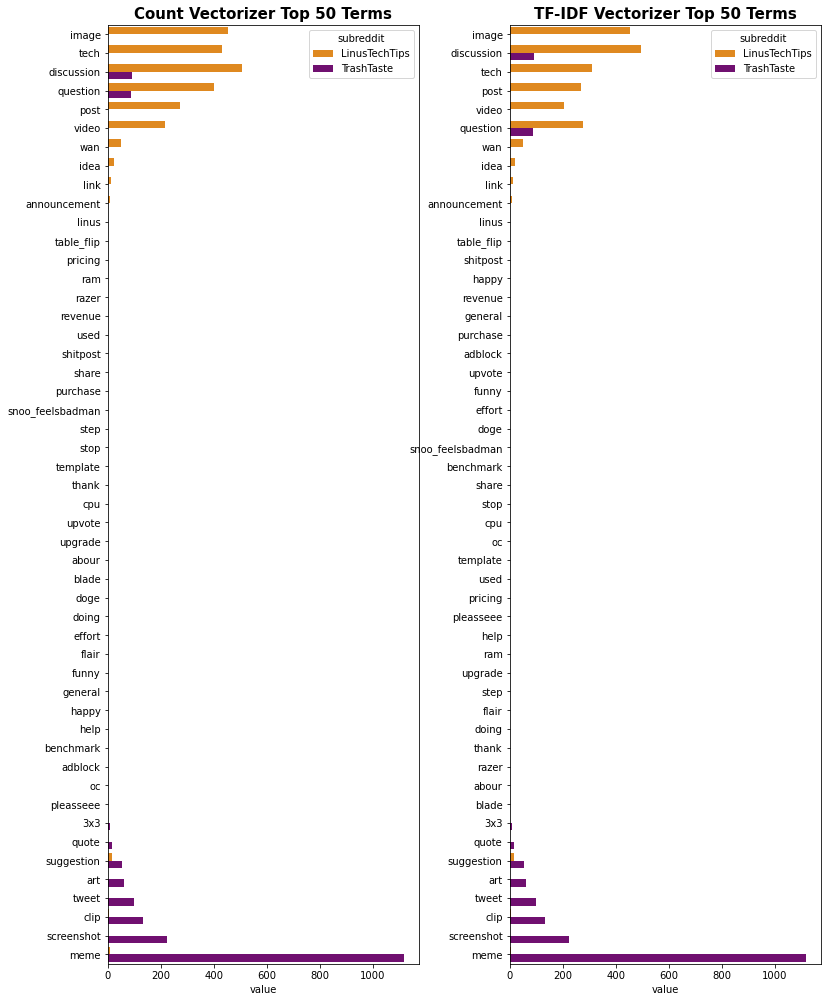

In [31]:
plot_term_chart(data, 'link_flair_text', ngram_range=(1,1))

In [32]:
features_obj

['author',
 'author_flair_richtext',
 'author_flair_text',
 'author_flair_type',
 'author_fullname',
 'author_premium',
 'domain',
 'id',
 'link_flair_background_color',
 'link_flair_css_class',
 'link_flair_richtext',
 'link_flair_template_id',
 'link_flair_text',
 'link_flair_type',
 'parent_whitelist_status',
 'selftext',
 'subreddit',
 'thumbnail',
 'title',
 'url',
 'whitelist_status',
 'post_hint',
 'preview',
 'url_overridden_by_dest',
 'media',
 'media_embed',
 'secure_media',
 'secure_media_embed',
 'crosspost_parent',
 'crosspost_parent_list',
 'removed_by_category',
 'gallery_data',
 'media_metadata',
 'author_flair_template_id',
 'author_flair_text_color',
 'poll_data',
 'author_flair_background_color']

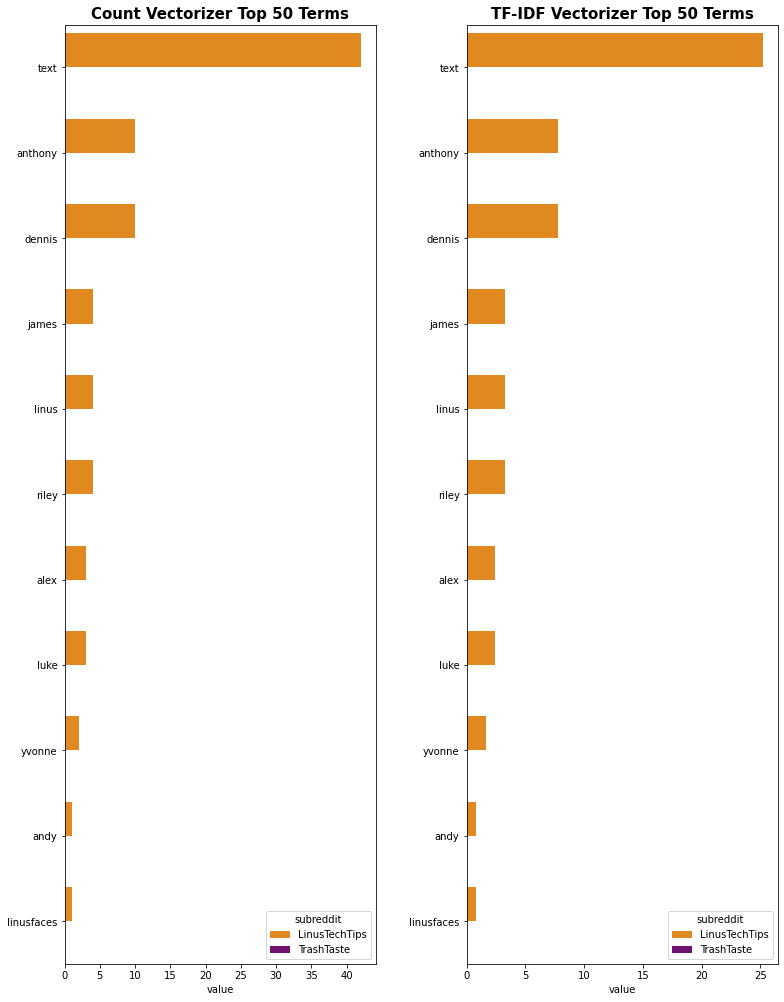

In [33]:
plot_term_chart(data, 'author_flair_richtext', ngram_range=(1,1))

<AxesSubplot:xlabel='subreddit', ylabel='created_utc'>

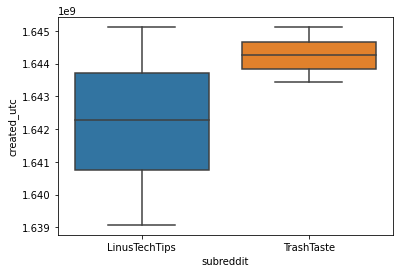

In [37]:
sns.boxplot(x='subreddit', y='created_utc', data=data)

In [67]:
data[data['subreddit']=='LinusTechTips']['created_year']

0       2022
1       2022
2       2022
3       2022
4       2022
        ... 
2095    2021
2096    2021
2097    2021
2098    2021
2099    2021
Name: created_year, Length: 2086, dtype: int64

<AxesSubplot:xlabel='created_datetime', ylabel='created_year'>

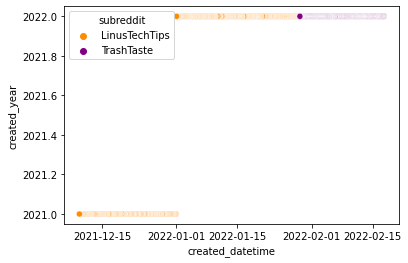

In [74]:
sns.scatterplot(x=data['created_datetime'], y = data['created_year'], hue=data['subreddit'], palette=['darkorange', 'purple'])

<AxesSubplot:xlabel='subreddit', ylabel='created_year'>

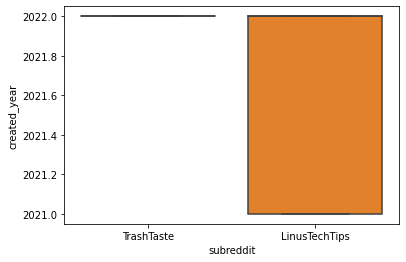

In [132]:
sns.boxplot(x=data['subreddit'], y=data['created_year'])

<AxesSubplot:xlabel='subreddit', ylabel='time_btw_post_(mins)'>

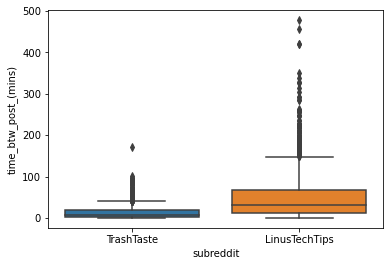

In [125]:
sns.boxplot(x=data['subreddit'], y=data['time_btw_post_(mins)'])

In [34]:
for col in linustech.columns:
    print(f'{col}: {linustech[col].unique()}\n')

Unnamed: 0: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]

all_awardings: ['[]']

allow_live_comments: [False  True]

author: ['jakze13' 'SpeedconG' 'Fab-Buns5166' ... 'clueless_as_fuck' 'RabiSzlomo'
 'OreoGamingGeek']

author_flair_css_class: [nan 'orangeflair']

author_flair_richtext: ['[]' "[{'e': 'text', 't': 'Anthony'}]" "[{'e': 'text', 't': 'Riley'}]"
 "[{'e': 'text', 't': 'Yvonne'}]" "[{'e': 'text', 't': 'Luke'}]" nan
 "[{'e': 'text', 't': 'James'}]" "[{'e': 'text', 't': 'Dennis '}]"
 "[{'e': 'text', 't': 'Alex'}]" "[{'e': 'text', 't': 'Linus'}]"
 "[{'e': 'text', 't': '/r/LinusFaces'}]" "[{'e': 'text', 't': 'Andy'}]"]

author_flair_text: [nan 'Anthony' 'Riley' 'Yvonne' 'Luke' 'James' 'Dennis ' 'Alex' 'Linus'
 '/r/LinusFaces

selftext: ['i wanted to upgrade my cpy cooler since my old pc is runing a bit hotter than i want i to. but the cpu cooler is stuck on my cpu.\n\nive seen people recoment twisting it. but unfortunatly that isnt possible due to the mounting mechanism. in the LTT spirrit, does anyhone have a janky way to get it off?'
 nan
 'My computer started failing out of nowhere after installing a clean windows 10 into a flash drive for a new build I was doing. Now my pc has the blue screen and it tries to fix the problem and states could not fix your pc. What can I do?'
 'because lenovo support is ass i didnt know who to ask so im here,\n\nmy laptop came with a genuine windows 10 pro copy but its asking me to activate windows. when i go into activation setting it says:\n\nwe cant activate your windows key as we cant connect to your organisations activition server.\n\nhelp!'
 " \n\nHey yall, so I built myself a new PC. I7 9700K 9th Gen CPU, GTX 1060 GPU, H310M S2 2.0 motherboard, a 500 watt power supp

crosspost_parent_list: [nan
 "[{'all_awardings': [], 'allow_live_comments': False, 'approved_at_utc': None, 'approved_by': None, 'archived': False, 'author': 'Zacker000', 'author_flair_background_color': '#4c9bee', 'author_flair_css_class': 'color-pcmr icon-windows text-laptop', 'author_flair_richtext': [{'a': ':windows:', 'e': 'emoji', 'u': 'https://emoji.redditmedia.com/u4ie3pkxdf131_t5_2sgp1/windows'}, {'e': 'text', 't': ' 2500K/5600XT | 4800HS/1660Ti'}], 'author_flair_template_id': '98ddc158-832e-11e9-91a9-0ef24765b0f4', 'author_flair_text': ':windows: 2500K/5600XT | 4800HS/1660Ti', 'author_flair_text_color': 'light', 'author_flair_type': 'richtext', 'author_fullname': 't2_1y7p1vne', 'author_is_blocked': False, 'author_patreon_flair': False, 'author_premium': False, 'awarders': [], 'banned_at_utc': None, 'banned_by': None, 'can_gild': True, 'can_mod_post': False, 'category': None, 'clicked': False, 'content_categories': None, 'contest_mode': False, 'created': 1645061482.0, 'created

In [35]:
# subreddit is the target, subreddit_id is the target
# Initial usable features are author, authur_fullname, 'full_link', 'domain', 'id', link_flair_richtext, link_flair_text, 
#'num_comments', 'permalink', 'selftext', 'title', 'url', whitelist_status', 'wls', 
# Dunno: 'created_utc'

In [36]:
for col in trashtaste.columns:
    print(f'{col}: {trashtaste[col].unique()}\n')

Unnamed: 0: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]

all_awardings: ['[]']

allow_live_comments: [False]

author: ['LMAO149' 'ytp4life' 'prefixaut' ... 'ichijoisbestgirl' '_X3N0XD'
 'SwRP_A_P']

author_flair_css_class: [nan]

author_flair_richtext: ['[]' nan]

author_flair_text: [nan 'Cultured' 'Man I Love Fishing' 'A Regular Here' 'Salty Salmon Slice'
 'Not Daijobu' 'Cross-Cultural Pollinator' '日本語上手'
 'Waiting Outside the Studio' 'Team Monke' 'Dr. Jelly'
 'Hambagu Connoisseur' 'Volcano Fan' 'Boneless Gang' 'Honorary Britannian'
 'Unofficial 4th Member' 'Affable' 'Worked at the BBC' 'ゴゴゴゴゴゴゴゴゴ'
 'Espresso Machine Owner' 'つよし' 'Not a Mouth Breather' 'In Gacha Debt'
 'Team Monk' 'Bidet Fanatic' 'Bone-In Gang' 'Drift King' 'Ca

crosspost_parent_list: [nan
 "[{'all_awardings': [], 'allow_live_comments': False, 'approved_at_utc': None, 'approved_by': None, 'archived': False, 'author': 'Palana', 'author_flair_background_color': None, 'author_flair_css_class': None, 'author_flair_richtext': [], 'author_flair_template_id': None, 'author_flair_text': None, 'author_flair_text_color': None, 'author_flair_type': 'text', 'author_fullname': 't2_m4zda', 'author_is_blocked': False, 'author_patreon_flair': False, 'author_premium': False, 'awarders': [], 'banned_at_utc': None, 'banned_by': None, 'can_gild': True, 'can_mod_post': False, 'category': None, 'clicked': False, 'content_categories': None, 'contest_mode': False, 'created': 1645047889.0, 'created_utc': 1645047889.0, 'discussion_type': None, 'distinguished': None, 'domain': 'i.redd.it', 'downs': 0, 'edited': False, 'gilded': 0, 'gildings': {}, 'hidden': False, 'hide_score': False, 'id': 'su7ayy', 'is_created_from_ads_ui': False, 'is_crosspostable': True, 'is_meta': F


author_flair_text_color: [nan 'dark']

gallery_data: [nan
 "{'items': [{'id': 112501013, 'media_id': 'tucmeyawfdi81'}, {'id': 112501014, 'media_id': 'bpdclmnwfdi81'}]}"
 "{'items': [{'id': 112158209, 'media_id': 'l8ck6il5j5i81'}, {'id': 112158210, 'media_id': 'fi4emjl5j5i81'}]}"
 "{'items': [{'caption': 'This is from their Hardest History Quiz stream recently.', 'id': 112148546, 'media_id': '4yvwxn6885i81'}, {'caption': 'The pink portion is muted due to copyright.', 'id': 112148547, 'media_id': 'oi90m41985i81'}]}"
 "{'items': [{'id': 112095219, 'media_id': 'xz932grv04i81'}, {'id': 112095220, 'media_id': 'g1qvgjjw04i81'}]}"
 "{'items': [{'id': 112044246, 'media_id': 'ssqkbfwvy2i81'}, {'id': 112044247, 'media_id': 'pi9jyawvy2i81'}]}"
 "{'items': [{'id': 112040897, 'media_id': 'oigiqw6gw2i81'}, {'id': 112040898, 'media_id': 'r4eoaw6gw2i81'}, {'id': 112040899, 'media_id': '5676pw6gw2i81'}]}"
 "{'items': [{'id': 111994096, 'media_id': 'nystu3tj32i81'}, {'id': 111994097, 'media_id': '6ebgc4